In [1]:
import numpy as np
import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from tqdm import tqdm
from Chempy.parameter import ModelParameters
import sbi.utils as utils
import time as t
import pickle
from plot_functions import *

/export/home/bguenes/anaconda3/envs/sbi_chempy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Posterior Samples

In [2]:
name = "NPE_C_nsf_20_10"

In [3]:
# ----- Load the data -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

elements = a.elements_to_trace

In [4]:
# ----- Load posterior -----
with open(f'data/posterior_{name}.pickle', 'rb') as f:
    posterior = pickle.load(f)

In [5]:
# ----- Load the NN -----
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(elements))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x
    
model = Model_Torch()
model.load_state_dict(torch.load('data/pytorch_state_dict_5sigma_uni_prior.pt'))
model.eval();

/tmp/ipykernel_4151398/1246384046.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/pytorch_state_dict_5sigma_uni_prior.pt'))


# Setup priors
The inputs to the model are drawn from a fixed set of global galaxy parameters (slope of the IMF & Rate of Type Ia Supernove) and a set of local star parameters.

In [6]:
local_GP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[2:]] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

global_GP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[:2]],
    validate_args=False)

# Simulate data
With the set global priors and for each $N_{\rm stars}$ a set of local priors, we can simulate the data with the Neural Network.

In [7]:
N_stars = 1000
simulations = 1000

stars = local_GP.sample((N_stars,))
global_params = torch.tensor([[-2.1, -3.0]])

stars = torch.cat((global_params.repeat(N_stars, 1), stars), dim=1)

In [8]:
# ----- Simulate abundances -----
start = t.time()
abundances = model(stars)  
# Remove H from data, because it is just used for normalization (output with index 2)
abundances = torch.cat([abundances[:,0:2], abundances[:,3:]], axis=1)
end = t.time()
print(f'Time to create data for {N_stars} stars: {end-start:.3f} s')

Time to create data for 1000 stars: 0.059 s


# SBI with 5% observation error noise
Need to load the posterior trained with a 5% observation error

In [9]:
def add_noise(true_abundances):
    # Define observational erorrs
    pc_ab = 5 # percentage error in abundance

    # Jitter true abundances and birth-times by these errors to create mock observational values.
    obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
    obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors)

    return obs_abundances

In [10]:
alpha_IMF_obs = []
log10_N_Ia_obs = []
simulations = 1000

start = t.time()
for i in tqdm(range(len(abundances))):
    x = add_noise(abundances[i].detach().numpy())
    alpha, N_Ia = posterior.sample((simulations,), x=x, show_progress_bars=False)[:,0:2].T
    alpha_IMF_obs.append(alpha)
    log10_N_Ia_obs.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF_obs = np.array(alpha_IMF_obs)
log10_N_Ia_obs = np.array(log10_N_Ia_obs)

  0%|          | 0/1000 [00:00<?, ?it/s]/export/home/bguenes/anaconda3/envs/sbi_chempy/lib/python3.12/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /croot/libtorch_1738269269729/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2190.)
  outputs, _ = torch.triangular_solve(
100%|██████████| 1000/1000 [01:14<00:00, 13.50it/s]

Time to run 1000 simulations for 1000 stars: 74.055 s


In [11]:
simulations = 1000
N_stars = 1000

# Predict Multistar Posterior
We can compute the posterior for a single star from the samples created in ```03_sample_from_posterior.ipynb```. <br>
Because of the central limit theorem, we can write the posterior for a single star as a multivariate Gaussian. <br>
This gives us the mean and covariance of $\alpha_{IMF}$ and $log{N_{Ia}}$ for one observation. <br>

We can then combine the posterior for multiple stars to get the posterior for the entire dataset. <br>
$$ 
\begin{align*}
P(\theta| data) &\propto \prod_{i=1}^{N_{stars}} P(\theta| obs_i) \\ \\
&\propto \prod_{i=1}^{N_{stars}} \exp\left(-\frac{1}{2} \frac{(\theta-\mu_i)^2}{\sigma_i^2}\right)
\end{align*} 
$$

This is a product of Gaussians, so the posterior for the entire dataset is also a Gaussian with mean $\mathbf{\mu}$ and variance $\mathbf{\sigma}$. <br>
$$
\begin{align*}
\mathbf{\mu} &= \frac{\sum_{i=1}^{N_{stars}} \frac{\mu_i}{\sigma_i^2}}{\sum_{i=1}^{N_{stars}} \frac1{\sigma_i^2}} \\ \\
\mathbf{\sigma}^2 &= \frac1 {\sum_{i=1}^{N_{stars}} \frac1{\sigma_i^2}}
\end{align*}
$$

In [12]:
mean_std(alpha_IMF_obs, mu_prior=-2.3, sigma_prior=0.3)

(-2.1176619648230783, 0.0026155709838355215)

In [13]:
mean_std(log10_N_Ia_obs, mu_prior=-2.89, sigma_prior=0.3)

(-2.9825788468552132, 0.0037860197960084053)

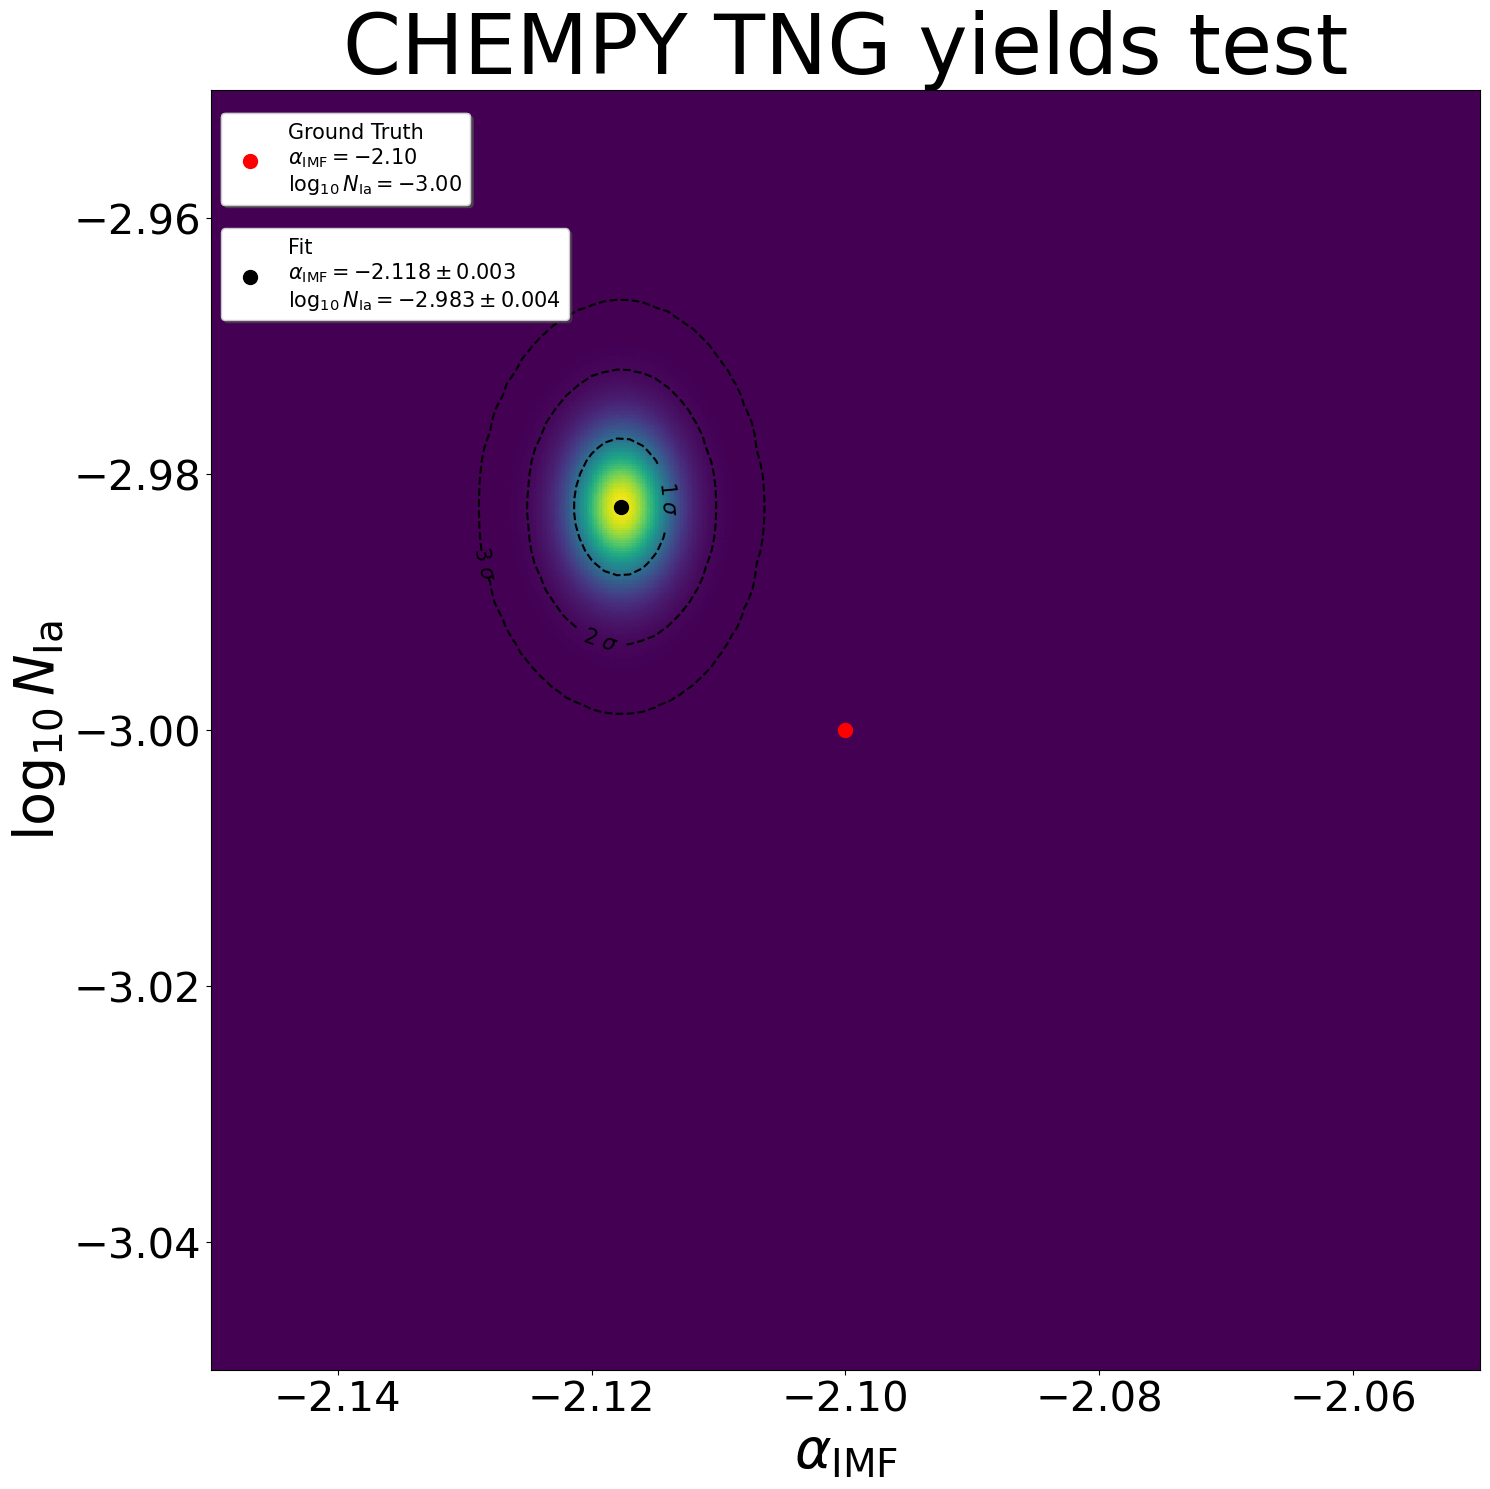

In [14]:
gaussian_posterior_plot(alpha_IMF_obs, log10_N_Ia_obs, global_params.numpy(), title="CHEMPY TNG yields test")

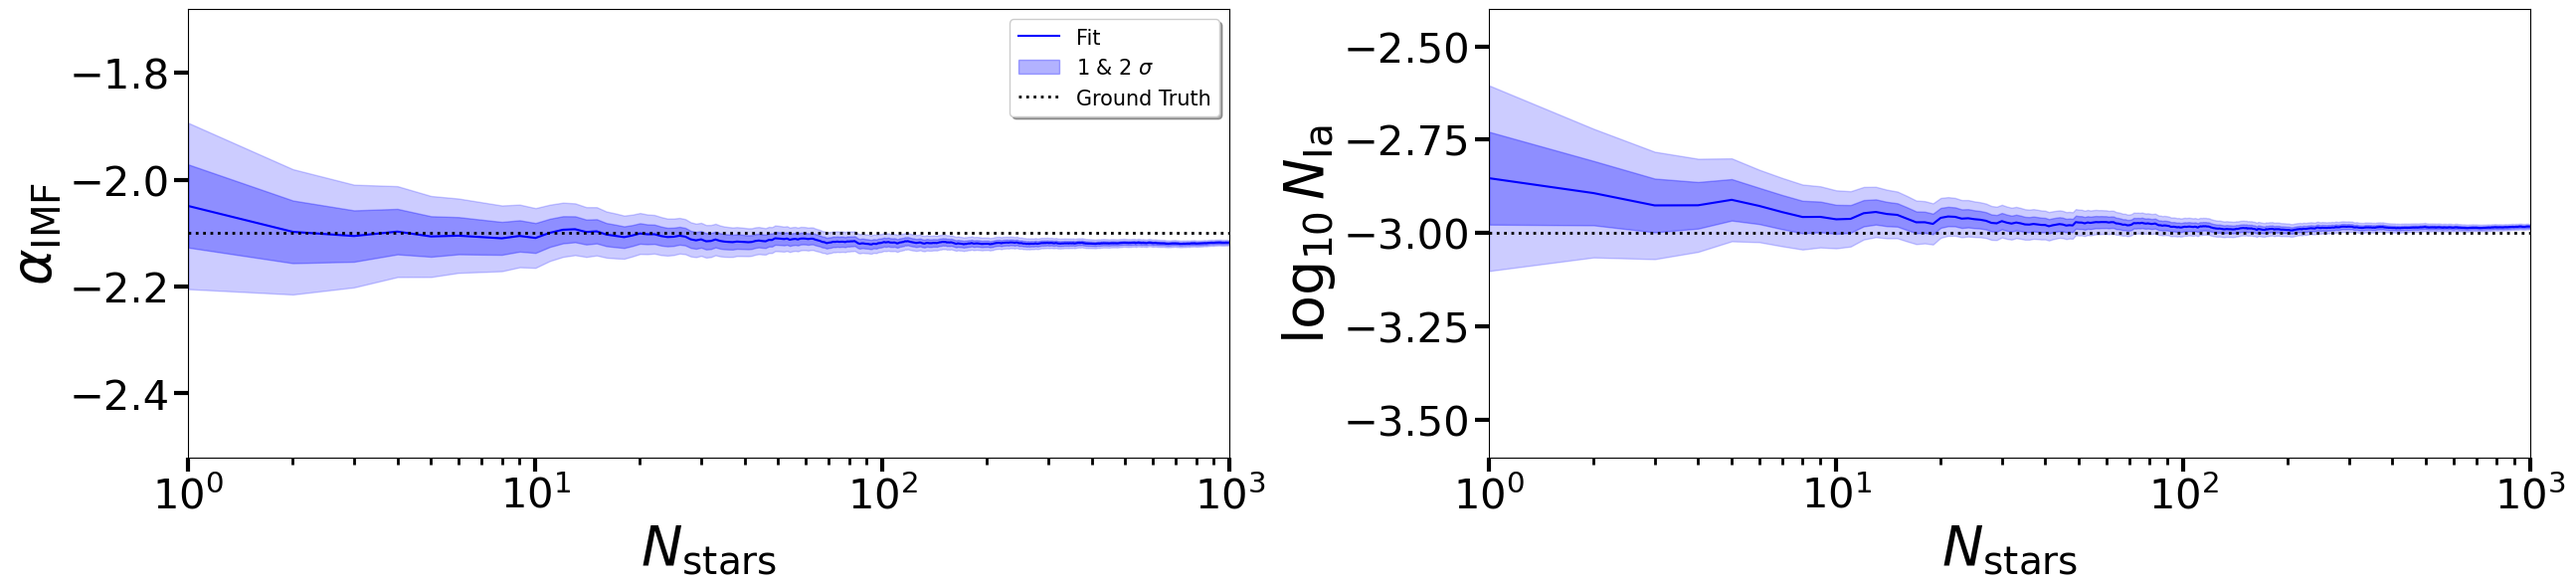

In [15]:
stars = np.arange(1,1000)
n_stars_plot(alpha_IMF_obs, log10_N_Ia_obs, global_params.numpy(), "CHEMPY TNG yields N_star test", stars)